In [0]:
from fastai.vision import *
from google.colab import drive
import pyrebase
from firebase import firebase
import re

#Loading Data into Dataloaders

In [0]:
#Creating folders for training
folders = ["cold sore","folliculitis","hives","jock itch","psoriasis","ringworm","shingles","tinea","warts"]
for idx,name_fol in enumerate(folders):
    dest = path/folders[idx]
    dest.mkdir(parents = True, exist_ok = True)

In [0]:
path = Path('/content/data')

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2, ds_tfms=get_transforms(), size=224, num_workers = 4)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (644 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
warts,warts,warts,warts,warts
Path: /content/data;

Valid: LabelList (160 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
ringworm,hives,ringworm,cold sore,psoriasis
Path: /content/data;

Test: None

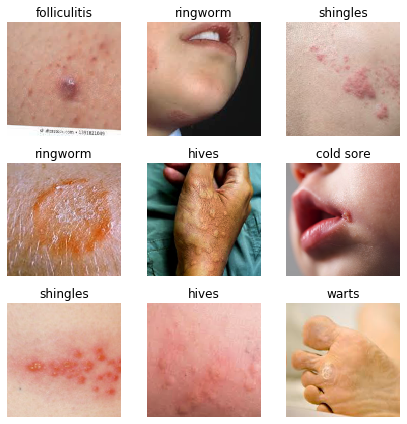

In [0]:
data.show(rows = 3, figsize=(6,6))

In [0]:
data.c,data.classes

(9,
 ['cold sore',
  'folliculitis',
  'hives',
  'jock itch',
  'psoriasis',
  'ringworm',
  'shingles',
  'tinea',
  'warts'])

In [0]:
len(data.valid_ds),len(data.train_ds)

(160, 644)

#Training the model wth Resnet-34

##Training on defaut mode

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(4)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,3.172080,1.946865,0.675000,00:27
1,2.352238,1.326757,0.393750,00:26
2,1.841552,1.190732,0.375000,00:26
3,1.520228,1.162570,0.375000,00:26


In [0]:
learn.save('stage-1')



```
# This is formatted as code
```

##Analyzing the results

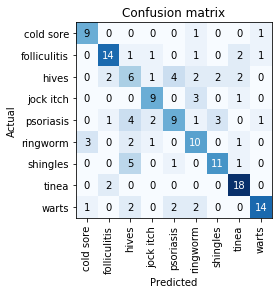

In [0]:
interep = ClassificationInterpretation.from_learner(learn)
interep.plot_confusion_matrix() 

In [0]:
interep.most_confused()

[('shingles', 'hives', 5),
 ('hives', 'psoriasis', 4),
 ('psoriasis', 'hives', 4),
 ('jock itch', 'ringworm', 3),
 ('psoriasis', 'shingles', 3),
 ('ringworm', 'cold sore', 3),
 ('folliculitis', 'tinea', 2),
 ('hives', 'folliculitis', 2),
 ('hives', 'ringworm', 2),
 ('hives', 'shingles', 2),
 ('hives', 'tinea', 2),
 ('psoriasis', 'jock itch', 2),
 ('ringworm', 'hives', 2),
 ('tinea', 'folliculitis', 2),
 ('warts', 'hives', 2),
 ('warts', 'psoriasis', 2),
 ('warts', 'ringworm', 2),
 ('cold sore', 'ringworm', 1),
 ('cold sore', 'warts', 1),
 ('folliculitis', 'hives', 1),
 ('folliculitis', 'jock itch', 1),
 ('folliculitis', 'ringworm', 1),
 ('folliculitis', 'warts', 1),
 ('hives', 'jock itch', 1),
 ('jock itch', 'tinea', 1),
 ('psoriasis', 'folliculitis', 1),
 ('psoriasis', 'ringworm', 1),
 ('psoriasis', 'warts', 1),
 ('ringworm', 'jock itch', 1),
 ('ringworm', 'tinea', 1),
 ('shingles', 'psoriasis', 1),
 ('shingles', 'tinea', 1),
 ('warts', 'cold sore', 1)]

##Unfreezing the N/W

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.load('stage-1')

In [0]:
learn.fit_one_cycle(5, max_lr=slice(1e-04,2e-03))

epoch,train_loss,valid_loss,error_rate,time
0,0.906020,1.213720,0.356250,00:26
1,0.741547,1.350291,0.281250,00:26
2,0.667093,1.277138,0.318750,00:26
3,0.556950,0.824916,0.231250,00:26
4,0.449916,0.688571,0.193750,00:26


#Backend inits

In [0]:
Firebase=pyrebase.initialize_app(config)
storage = Firebase.storage()
db = Firebase.database()

In [0]:
storage.child("Images/1581789250326.jpg").download('1581789250326.jpg')

#Deployment

##Diagnosis

In [0]:
from fastai.vision import *

In [0]:
img = open_image('/content/1581789250326.jpg')
img

In [1]:
learn=load_learner('/content/data/')
pred, pred_idx, outputs = learn.predict(img)
print("Diagnosis:",pred)

Diagnosis:psoriasis


##Medication

In [0]:
from firebase import firebase
firebase = firebase.FirebaseApplication("https://hackathon-58fa0.firebaseio.com/",None)

In [0]:
var=str(pred).capitalize()
result = firebase.get('/MedRec',var)
print(result)
firebase.patch('/Response/User',result)

{'Disease Name': 'Psoriasis', 'Drug': 'Corticosteroid', 'Ointments': 'Anthralin®', 'Selfcare': 'UV light therapy.'}
